# Радарные графики по неделям

In [350]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
#from sklearn.cross_validation import cross_val_score
#from sklearn.cross_validation import cross_val_predict
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import cm, rc
%matplotlib inline
from alex.database import Database
from pprint import pprint
from statsmodels.tsa.stattools import adfuller # Расширенный тест Дики-Фуллера
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
import time

### Загрузка данных

In [424]:
# загрузка истории
# 20 секунд
start = time.time()
db = Database()
# sql_history = f"select * from v_history where exchange='binance' and pair='ETH/USDT' and dt>'2018-07-01'"
sql_history = f"select dt, price, amount, side from v_history " \
              f"where id_ex_pair=19 and dt>'2018-07-01' order by dt"
              #f"and location='memory'" \
df_history = db.query(sql_history)
df_history.set_index('dt', inplace=True)
df_history.index = pd.to_datetime(df_history.index)
df_history.side = df_history.side.astype('category')
print(f"Loading time: {time.time()-start:.02f} sec")

Loading time: 19.68 sec


In [425]:
df_history.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4344627 entries, 2018-08-07 03:18:34 to 2018-10-23 10:22:16
Data columns (total 3 columns):
price     float64
amount    float64
side      category
dtypes: category(1), float64(2)
memory usage: 103.6 MB


In [429]:
df_history.shape # (4329127, 11)

(4344627, 3)

In [427]:
df_history.tail()

,price,amount,side
dt,,,
2018-10-23 10:21:59,205.949997,0.61685,sell
2018-10-23 10:22:07,206.009995,0.10160,buy
2018-10-23 10:22:11,205.990005,0.51839,buy
2018-10-23 10:22:16,205.960007,2.00905,buy
2018-10-23 10:22:16,205.940002,1.32173,sell


### Препроцессинг

In [500]:
# Добавление даты номера недели и дня недели

#df = df_history.reset_index()
df = df_history.copy()
#df['time'] = pd.to_datetime(df_history.dt)
df['weekno'] = df_history.index.weekofyear
df['dayweek'] = df_history.index.weekday
df.head()

,price,amount,side,weekno,dayweek
dt,,,,,
2018-08-07 03:18:34,406.399994,3.50655,sell,32,1
2018-08-07 03:18:34,406.630005,0.03000,buy,32,1
2018-08-07 03:18:41,406.329987,4.31794,sell,32,1
2018-08-07 03:18:41,406.470001,6.13147,buy,32,1
2018-08-07 03:18:42,406.609985,1.71500,buy,32,1


In [440]:
# Формирование нового датафрейма w, где средняя цена, сгрупированная по неделям и дням недели
w=df.groupby(['weekno','dayweek'])[['price']].mean()#.to_excel('dayofweek.xlsx')#(#.pct_change().plot(kind='bar')

# добавление поля ks (коэф.сез.) - средняя цена дня делится на среднюю цену недели, к которой этот день принадлежит
w['ks'] = w.price / w.groupby('weekno').price.mean()
w.reset_index(inplace=True)

# расчет корреляции между номером дня недели и "коэф.сезонности" данного дня
w.ks.corr(w.dayweek)

-0.19368857726466232

## Radar plots

In [463]:
# полные недели
# weeks = w[(w.weekno>=35) & (w.weekno<43)]
weeks = w[w.weekno>=35]

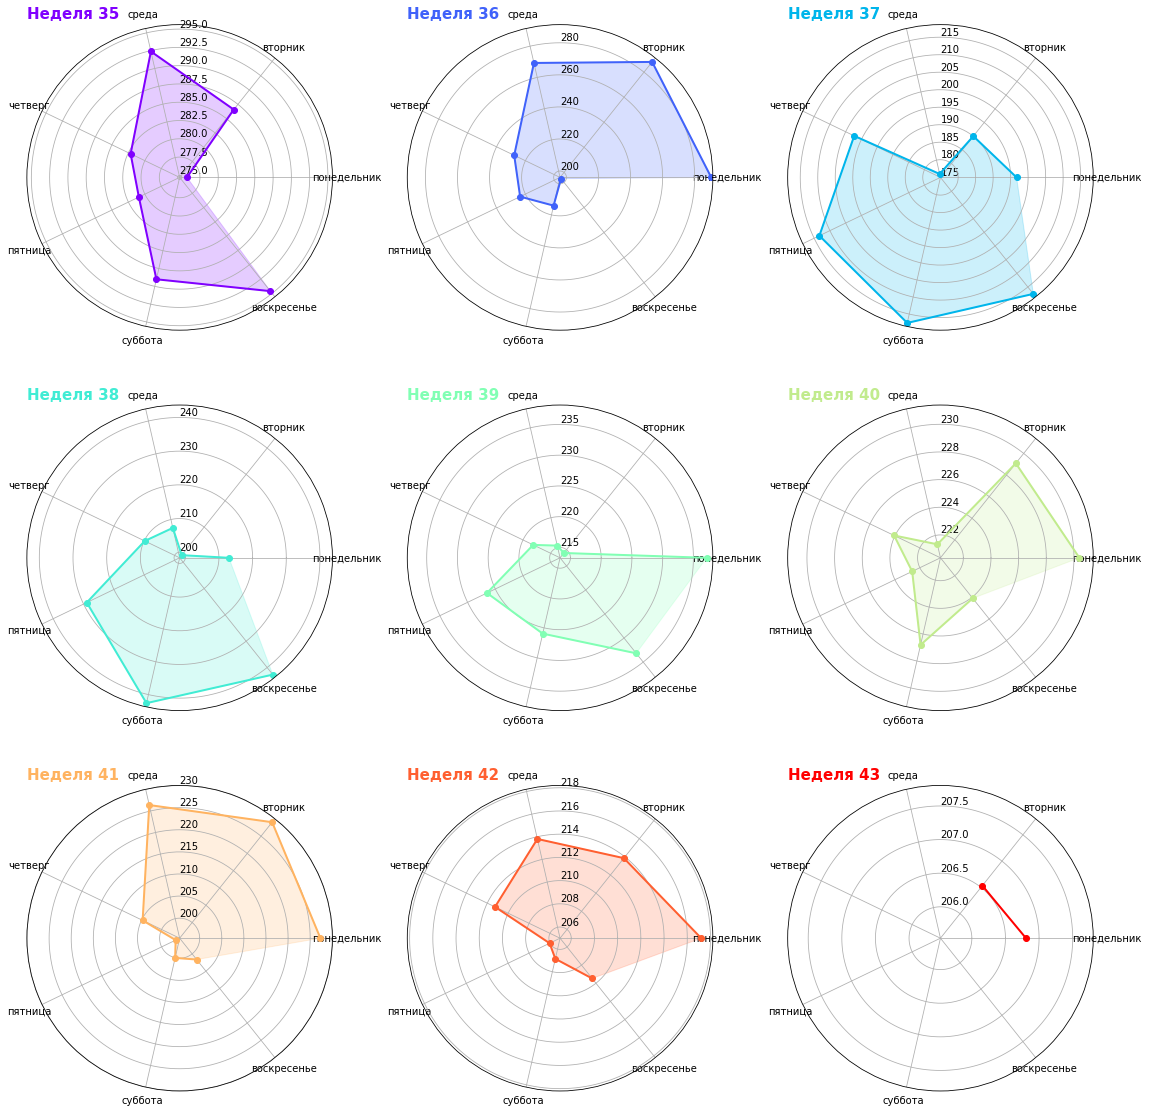

In [530]:
# MULTI-RADAR
# создаём итератор цветов. Цвета берем из радуги, которую делим на кол-во графиков
colors = iter(cm.rainbow(np.linspace(0, 1, len(weeks.weekno.unique()))))

# дни недели
categories = ['понедельник','вторник','среда','четверг','пятница','суббота','воскресенье']
N = len(categories)
angles = [n/float(N) * 2 * np.pi for n in range(N)]

cols = 3 # кол-во колонок в графике
rows = int(np.ceil(len(weeks.weekno.unique())/cols)) # кол-во строк в графике
fig, axs = plt.subplots(rows, cols, 
                        subplot_kw=dict(projection='polar'), figsize=(16, 16))

x, y = 0, 0 # координаты каждого из рисунков
for weekno in weeks.weekno.unique():
    week = weeks[weeks.weekno==weekno]
    values = week.price.values

    minval, maxval = np.min(week.price.values), np.max(week.price.values)
    yticks = [int(y) for y in np.arange(minval-1, maxval+1, step=1.0)]

    color = next(colors) # ротация цветов

    ax = axs[x, y]
    ax.set_title(f'Неделя {weekno}', loc='left', size=15, color=color, fontweight='bold')
    ax.set_xticks(angles)          # установка кол-ва углов, соответстующих кол-ву дней в неделе
    ax.set_xticklabels(categories) # надписи дней недели
    ax.set_rlabel_position(90)     # цены распологаю вертикально, чтоб не пересекались с осями
    ax.set_ylim(minval-1, maxval+1)

    ax.fill(angles[:len(values)], values, color=color, alpha=0.2)
    ax.plot(angles[:len(values)], values, color=color, linewidth=2, linestyle='solid', marker='o')
    
    if y>=cols-1:
        y=0
        x+=1 
    else:
        y+=1

# удаляем пустые графики
empty_plots = rows*cols - len(weeks.weekno.unique())
if empty_plots>0:
    fig.delaxes(axs.flatten()[-empty_plots])

fig.tight_layout()
plt.show()

In [470]:
def single_radar(categories, values, heading='', color='r'):
    N = len(categories)
    angles = [n/float(N) * 2 * np.pi for n in range(N)]
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

    minval, maxval = np.min(values), np.max(values)
    yticks = [int(y) for y in np.arange(minval-1, maxval+1, step=1.0)]
    
    if heading!='':
        ax.set_title(heading, loc='left', size=15, color=color, fontweight='bold')
    ax.set_xticks(angles)          # установка кол-ва углов, соответстующих кол-ву дней в неделе
    ax.set_xticklabels(categories) # надписи дней недели
    ax.set_rlabel_position(90)     # цены распологаю вертикально, чтоб не пересекались с осями
    ax.set_ylim(minval-1, maxval+1)

    ax.fill(angles[:len(values)], values, color=color, alpha=0.2)
    ax.plot(angles[:len(values)], values, color=color, linewidth=2, linestyle='solid', marker='o')
    plt.show()

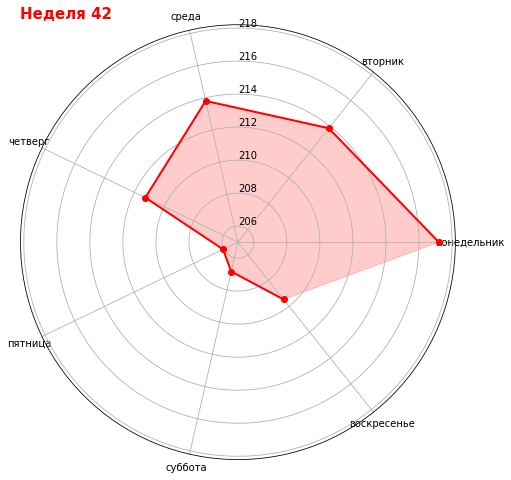

In [481]:
week = w[w.weekno==42]
heading = f"Неделя {week.head(1).weekno.values[0]}"
categories = ['понедельник','вторник','среда','четверг','пятница','суббота','воскресенье']
values = week.price.values

single_radar(categories=categories, values=values, heading=heading, color='red')

## Поиск часа внутри дня, в котором бы наблюдалось падение или рост по сравнению с предыдущим часом

In [531]:
df_history.tail()

,price,amount,side
dt,,,
2018-10-23 10:21:59,205.949997,0.61685,sell
2018-10-23 10:22:07,206.009995,0.10160,buy
2018-10-23 10:22:11,205.990005,0.51839,buy
2018-10-23 10:22:16,205.960007,2.00905,buy
2018-10-23 10:22:16,205.940002,1.32173,sell


In [559]:
# группирую исходные данные по часам. Цены беру медианные, а суммы складываю.
hours = df_history[df_history.index>='2018-08'][
    ['price', 'amount']].resample('H').agg({'price':'median', 'amount':'sum'})

# добавляю колонку с номером дня
hours['day'] = hours.index.day

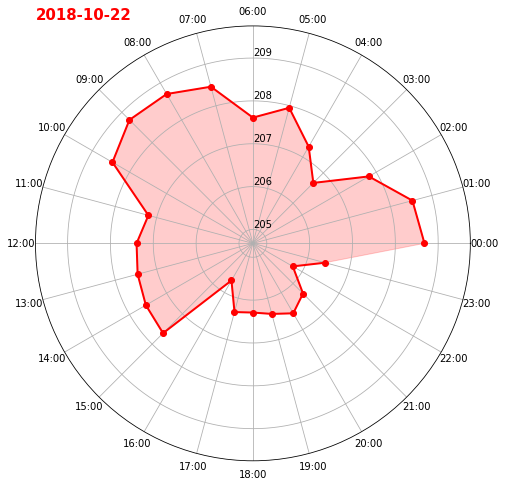

In [582]:
date = '2018-10-22'
heading = f'{date}'
categories = [f"{x:02d}:00" for x in np.arange(0,24,dtype=int)] # часы в сутках
values = hours[date].price.values

single_radar(categories=categories, values=values, heading=heading, color='red')

In [ ]:
# поиск часа, в котором бы чаще наблюдалось падение или рост